In [52]:
from CallCentreEnvironment import CallCentreEnv, CallCentreEnvPPO
import numpy as np
import pandas as pd
import gym
import matplotlib.pyplot as plt
import os
import pickle
from stable_baselines3 import PPO
from sb3_contrib import MaskablePPO
from stable_baselines3.common.callbacks import EvalCallback
from sb3_contrib.common.maskable.utils import get_action_masks
from sb3_contrib.common.maskable.callbacks import MaskableEvalCallback

def plot_history(history):
    num_metrics = len(history.keys())
    num_cols = 2  # Two plots per row
    num_rows = (num_metrics + 1) // num_cols  # Calculate number of rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5 * num_rows))
    axes = axes.flatten()  # Flatten in case of single-row layout

    for idx, (key, values) in enumerate(history.items()):
        values = np.array(values)

        # Handle nested lists by taking mean per episode if necessary
        if isinstance(values[0], list):
            values = np.array([np.mean(v) for v in values])

        # Plot the values
        axes[idx].plot(values, label=key, color='blue', alpha=0.7)
        axes[idx].axhline(np.mean(values), color='red', linestyle='--', label=f"Avg {key}: {np.mean(values):.2f}")

        # Labels and titles
        axes[idx].set_xlabel("Episode")
        axes[idx].set_ylabel(key)
        axes[idx].set_title(key)
        axes[idx].legend()
        axes[idx].grid(True)

    # Hide any unused subplots (if total plots are odd)
    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

def random_action_simulation(env, num_episodes=1000, name = "random_history"):
    try:
        with open(f"./Project_Data/{name}.pkl", "rb") as f:
            history = pickle.load(f)
    except FileNotFoundError:
        history = dict()
        history['rewards'] = []

        # Dynamically initialize history keys based on _system_statistics
        sample_stats = env._system_statistics()
        for key in sample_stats.keys():
            history[key] = []

        for episode in range(num_episodes):
            state = env.reset()
            total_reward = 0
            done = False

            while not done:
                mask = env.action_masks()
                valid_actions = np.where(mask == 1)[0]

                if len(valid_actions) == 0:
                    action = env.action_space.sample()
                else:
                    action = np.random.choice(valid_actions)

                next_state, reward, done, _ = env.step(action)
                total_reward += reward

            history["rewards"].append(total_reward)

            # Collect statistics from the environment
            result = env._system_statistics()
            for key, value in result.items():
                if key not in history:
                    history[key] = []  # Handle any new keys added later
                history[key].append(value)

        # Save the updated history
        with open(f"./Project_Data/{name}.pkl", "wb") as f:
            pickle.dump(history, f)

    return history

def compute_random_metrics(random_history, name):
    random_metric = [
        "total_clients", "abandonment_rate", "mean_waiting_time_action", "mean_idle_time_action",
        "mean_callback_waiting_time_action", "max_callback_queue_size", "max_staff_0_queue_size",
        "max_staff_1_queue_size", "max_staff_2_queue_size", "max_staff_3_queue_size",
        "max_staff_4_queue_size", "max_staff_5_queue_size", "max_staff_6_queue_size",
        "max_staff_7_queue_size"
    ]

    random_metrics_results = {}

    for metric in random_metric:
        if metric.startswith("max"):
            random_metrics_results[metric] = max(random_history[metric])
        else:
            values = random_history[metric]
            random_metrics_results[metric] = sum(values) / len(values) if values else 0

    return pd.DataFrame([random_metrics_results]).T.rename(columns={0: name})

**Scaled-up parameter**

In [53]:
parameters = {
    'time_until': 30500,
    'arrival_rate': [3412,3595,3389,3361,3573],
    'service_rate': [
        [[29,419],[27,413],[27,423],[7,413],[28,412]],
        [[42,418],[31,425],[37,444],[35,419],[25,431]],
        [[24,421],[24,434],[16,384],[39,403],[46,392]],
        [[14,422],[46,447],[4,373],[56,439],[37,431]],
        [[45,416],[46,426],[33,382],[58,416],[52,396]],
        [[42,421],[20,397],[15,424],[53,406],[28,426]],
        [[21,431],[42,408],[28,410],[35,399],[40,419]],
        [[49,431],[31,417],[31,411],[27,435],[18,410]]],
    'abandonment_rate': [8108, 7534, 7743, 7247, 7439],
    "wrap_up_time": [
                [90, 100, 75, 80, 100], 
                [80, 140, 95, 100, 110],
                [80, 100, 85, 95, 100], 
                [95, 110, 85, 90, 120], 
                [85, 130, 95, 75, 110],
                [70, 100, 90, 100, 150],
                [92, 120, 95, 101, 120],
                [100, 120, 75, 79, 100]]
    }
    

scalee_up_parameters = {
    'time_until': 30500,
    'arrival_rate': [284, 300, 282, 280, 298],
    'abandonment_rate': [405, 377, 387, 362, 372],
    'service_rate': [
        [[44, 628], [40, 620], [40, 634], [10, 620], [42, 618]],
        [[63, 627], [46, 638], [56, 666], [52, 628], [38, 646]],
        [[36, 632], [36, 651], [24, 576], [58, 604], [69, 588]],
        [[21, 633], [69, 670], [6, 560], [84, 658], [56, 646]],
        [[68, 624], [69, 639], [50, 573], [87, 624], [78, 594]],
        [[63, 632], [30, 596], [22, 636], [80, 609], [42, 639]],
        [[32, 646], [63, 612], [42, 615], [52, 598], [60, 628]],
        [[74, 646], [46, 626], [46, 616], [40, 652], [27, 615]]]
        ,
    "wrap_up_time": [
                [90, 100, 75, 80, 100], 
                [80, 140, 95, 100, 110],
                [80, 100, 85, 95, 100], 
                [95, 110, 85, 90, 120], 
                [85, 130, 95, 75, 110],
                [70, 100, 90, 100, 150],
                [92, 120, 95, 101, 120],
                [100, 120, 75, 79, 100]]
}

## 1. Model Exploration

In [34]:
original_env = CallCentreEnv(parameters)
original_exploration_history = random_action_simulation(original_env, 1000, "original_exploration")
original_exploration_df = compute_random_metrics(original_exploration_history, "original")

In [35]:
scale_up_env = CallCentreEnv(scalee_up_parameters)
scale_up_exploration_history = random_action_simulation(scale_up_env, 1000, "scale_up_exploration")
scale_up_exploration_df = compute_random_metrics(scale_up_exploration_history, "scaled_up")

In [36]:
pd.concat([original_exploration_df, scale_up_exploration_df], axis=1)

,original,scaled_up
total_clients,48.555000,534.453000
abandonment_rate,0.000974,0.173023
mean_waiting_time_action,0.745233,42.182768
mean_idle_time_action,26125.395111,304.974449
mean_callback_waiting_time_action,8.220075,32.369787
max_callback_queue_size,3.000000,23.000000
max_staff_0_queue_size,2.000000,5.000000
max_staff_1_queue_size,3.000000,5.000000
max_staff_2_queue_size,3.000000,5.000000
max_staff_3_queue_size,3.000000,5.000000


## 2. PPO training

In [37]:
# # Create PPO model
# ppo_env = CallCentreEnvPPO(scalee_up_parameters)
# ppo_eval_env = CallCentreEnvPPO(scalee_up_parameters)

# # Define the evaluation callback
# eval_callback = MaskableEvalCallback(
#     ppo_eval_env,
#     best_model_save_path='./Project_Data/best_model/',
#     log_path='./Project_Data/logs/',
#     eval_freq=10000,                 # Evaluate every 10,000 steps
#     deterministic=True,
#     render=False
# )

# # Initialize PPO model
# model = MaskablePPO(
#     "MlpPolicy",
#     ppo_env,
#     verbose=1,
#     learning_rate=0.0003,
#     n_steps=2048,
#     batch_size=64,
#     ent_coef=0.01,
#     tensorboard_log="./Project_Data/ppo_logs/"
# )

# # Train the model with the evaluation callback
# model.learn(
#     total_timesteps=5000000,
#     callback=eval_callback
# )

# # Save the final model
# model.save("./Project_Data/ppo_call_center")

In [38]:
# !tensorboard --logdir=ppo_logs

In [39]:
def model_simulation(env, model, model_name, num_episodes=1000):
    try:
        with open(f"./Project_Data/{model_name}_history.pkl", "rb") as f:
            history = pickle.load(f)
    except FileNotFoundError:
        history = dict()
        history['rewards'] = []

        # Dynamically initialize history keys based on _system_statistics
        sample_stats = env._system_statistics()
        for key in sample_stats.keys():
            history[key] = []

        for episode in range(num_episodes):
            state = env.reset()
            total_reward = 0
            done = False

            while not done:
                action_masks = env.action_masks()
                action, _ = model.predict(state, deterministic=True, action_masks=action_masks)
                state, reward, done, _ = env.step(action)
                total_reward += reward

            history["rewards"].append(total_reward)

            # Collect statistics from the environment
            result = env._system_statistics()
            for key, value in result.items():
                if key not in history:
                    history[key] = []  # Handle any new keys added later
                history[key].append(value)

            # Optional: Progress logging every 100 episodes
            # if (episode + 1) % 100 == 0:
            #     print(f"Episode {episode + 1}/{num_episodes}")

        # Save updated history
        with open(f"./Project_Data/{model_name}_history.pkl", "wb") as f:
            pickle.dump(history, f)

    return history

### 2.1 Training and Evaluation Curve 

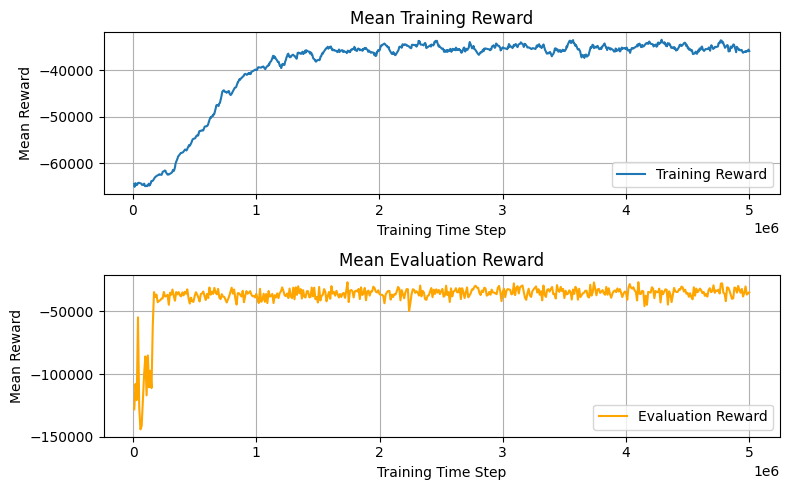

In [40]:
# Load data
evaluation_history = pd.read_csv("./Project_Data/PPO_evaluation.csv")
reward_history = pd.read_csv("./Project_Data/PPO_training.csv")

# Create 2x1 subplot
fig, axes = plt.subplots(2, 1, figsize=(8, 5))

# Subplot 1: Evaluation reward
axes[0].plot(reward_history["Step"], reward_history["Value"], label='Training Reward', linewidth=1.5)
axes[0].set_xlabel('Training Time Step')  # <-- added x-axis label here
axes[0].set_ylabel('Mean Reward')
axes[0].set_title('Mean Training Reward')
axes[0].grid(True)
axes[0].legend()

# Subplot 2: Training reward
axes[1].plot(evaluation_history["Step"], evaluation_history["Value"], label='Evaluation Reward', linewidth=1.5, color='orange')
axes[1].set_xlabel('Training Time Step')
axes[1].set_ylabel('Mean Reward')
axes[1].set_title('Mean Evaluation Reward')
axes[1].grid(True)
axes[1].legend()

# Layout
plt.tight_layout()
plt.show()


### 2.2 Policy Action Analysis

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

def random_simulate_and_collect_data(parameters, num_episodes=100, name = "random_action_df"):
    """
    Runs simulation episodes using a call center environment, collects event data, and returns it as a DataFrame.
    
    Parameters:
    - env_class: The environment class (e.g., CallCenterEnvPPO).
    - parameters: The parameters to initialize the environment.
    - num_episodes: Number of simulation episodes to run.
    
    Returns:
    - pd.DataFrame with collected event data.
    """
    try:
        with open(f"./Project_Data/{name}.pkl", "rb") as f:
            pivoted = pickle.load(f)
    except FileNotFoundError:

        records = []

        for episode in range(num_episodes):
            random_env = CallCentreEnvPPO(parameters)
            obs = random_env.reset()
            done = False

            while not done:
                action_masks = random_env.action_masks()
                valid_actions = np.where(action_masks == 1)[0]

                if len(valid_actions) == 0:
                    action = random_env.action_space.sample()
                else:
                    action = np.random.choice(valid_actions)

                next_obs, reward, done, info = random_env.step(action)

            # Collect event data from the simulation
            for snapshot in random_env.happened_event:
                event_name = snapshot.get('Event', '')  # Event name or type
                if "Arrival" in event_name or "After Call Back" in event_name:
                    obs = snapshot.get('Observation', None)
                    if isinstance(obs, list) or isinstance(obs, np.ndarray):
                        decision_type = obs[-1]
                        inquiry_type = int(obs[-2] * len(random_env.arrival_rate)) 

                        action = snapshot.get('Action', 'N/A')
                        staff_queue_sizes = snapshot.get('StaffQueueSizes', [])
                        total_queue_size = sum(staff_queue_sizes) if staff_queue_sizes else 0
                        callback_queue_size = snapshot.get('CallBackQueueSizes', 0)

                        record = {
                            'event_name': event_name,
                            'decision_type': decision_type,
                            'inquiry_type': inquiry_type,
                            'action': action,
                            'queue_size': total_queue_size,
                            'callback_queue_size': callback_queue_size
                        }

                        for i, size in enumerate(staff_queue_sizes):
                            record[f'staff_queue_size_{i}'] = size

                        records.append(record)
            
        
        agg = (pd.DataFrame(records)
            .groupby(['decision_type', 'inquiry_type', 'queue_size', 'callback_queue_size', 'action'])
            .size()
            .reset_index(name='frequency'))

        # Pivot so 'action' becomes its own column
        pivoted = agg.pivot_table(
            index=['decision_type', 'inquiry_type', 'queue_size', 'callback_queue_size'],
            columns='action',
            values='frequency',
            fill_value=0
        ).reset_index()

        # Save the updated history
        with open(f"./Project_Data/{name}.pkl", "wb") as f:
            pickle.dump(pivoted, f)

    return pivoted



def ppo_simulate_and_collect_data(parameters, model = "ppo_call_center", num_episodes=100, name = "ppo_action_df"):
    """
    Runs simulation episodes using a call center environment, collects event data, and returns it as a DataFrame.
    
    Parameters:
    - env_class: The environment class (e.g., CallCenterEnvPPO).
    - parameters: The parameters to initialize the environment.
    - num_episodes: Number of simulation episodes to run.
    
    Returns:
    - pd.DataFrame with collected event data.
    """
    try:
        with open(f"./Project_Data/{name}.pkl", "rb") as f:
            pivoted = pickle.load(f)
    except FileNotFoundError:

        model = MaskablePPO.load(model)

        records = []

        for episode in range(num_episodes):
            ppo_env = CallCenterEnvPPO(parameters)
            obs = ppo_env.reset()
            done = False

            while not done:
                action_masks = ppo_env.action_masks()
        
                # Predict action using the model
                action, _ = model.predict(obs, action_masks=action_masks)

                next_obs, reward, done, info = ppo_env.step(action)

            # Collect event data from the simulation
            for snapshot in ppo_env.happened_event:
                event_name = snapshot.get('Event', '')  # Event name or type
                if "Arrival" in event_name or "After Call Back" in event_name:
                    obs = snapshot.get('Observation', None)
                    if isinstance(obs, list) or isinstance(obs, np.ndarray):
                        decision_type = obs[-1]
                        inquiry_type = int(obs[-2] * len(ppo_env.arrival_rate) ) # Scale inquiry type to match the environment

                        action = snapshot.get('Action', 'N/A')
                        staff_queue_sizes = snapshot.get('StaffQueueSizes', [])
                        total_queue_size = sum(staff_queue_sizes) if staff_queue_sizes else 0
                        callback_queue_size = snapshot.get('CallBackQueueSizes', 0)

                        record = {
                            'event_name': event_name,
                            'decision_type': decision_type,
                            'inquiry_type': inquiry_type,
                            'action': action,
                            'queue_size': total_queue_size,
                            'callback_queue_size': callback_queue_size
                        }

                        for i, size in enumerate(staff_queue_sizes):
                            record[f'staff_queue_size_{i}'] = size

                        records.append(record)
        
        ppo_df = pd.DataFrame(records)
        ppo_df['queue_size'] = ppo_df['queue_size'].astype(int)
        ppo_df['action'] = ppo_df['action'].astype(int)

        agg = (ppo_df
            .groupby(['decision_type', 'inquiry_type', 'queue_size', 'callback_queue_size', 'action'])
            .size()
            .reset_index(name='frequency'))

        # Pivot so 'action' becomes its own column
        pivoted = agg.pivot_table(
            index=['decision_type', 'inquiry_type', 'queue_size', 'callback_queue_size'],
            columns='action',
            values='frequency',
            fill_value=0
        ).reset_index()

        # Save the updated history
        with open(f"./Project_Data/{name}.pkl", "wb") as f:
            pickle.dump(pivoted, f)

    return pivoted


def plot_action_heatmaps(df):

    pivoted = df.copy()

    # Add most frequent action to the DataFrame
    pivoted['most_freq_action'] = pivoted[list(range(8))].idxmax(axis=1)

    df2 = pivoted[['decision_type', 'inquiry_type', 'queue_size', 'callback_queue_size', 'most_freq_action']]

    action_vals = sorted(df2['most_freq_action'].dropna().unique())
    n_actions = len(action_vals)
    palette = sns.color_palette("tab10", n_colors=n_actions)
    cmap = ListedColormap(palette)
    bounds = [val - 0.5 for val in action_vals] + [action_vals[-1] + 0.5]
    norm = BoundaryNorm(bounds, n_actions)

    decision_types = sorted(df2['decision_type'].unique())
    inquiry_types = sorted(df2['inquiry_type'].unique())
    n_rows, n_cols = len(decision_types), len(inquiry_types)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), sharex=False, sharey=False)
    axes = np.atleast_2d(axes)

    x_ticks = sorted(df2['callback_queue_size'].unique())
    y_ticks = sorted(df2['queue_size'].unique())

    for i, d in enumerate(decision_types):
        for j, q in enumerate(inquiry_types):
            ax = axes[i, j]
            sub_df = df2[(df2['decision_type'] == d) & (df2['inquiry_type'] == q)]

            ax.set_xlabel('Callback queue size', labelpad=8)
            ax.set_ylabel('Live queue size', labelpad=8)
            ax.set_xticks(x_ticks)
            ax.set_yticks(y_ticks)
            ax.set_xticklabels(x_ticks, rotation=90)
            ax.set_yticklabels(y_ticks, rotation=0)
            ax.set_title(f"Decision = {d}, Inquiry = {q}", pad=10)

            if sub_df.empty:
                ax.text(0.5, 0.5, 'no data', ha='center', va='center', fontsize=12)
                continue

            heatmap_df = (
                sub_df
                .groupby(['queue_size', 'callback_queue_size'])['most_freq_action']
                .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
                .reset_index()
                .pivot(index='queue_size', columns='callback_queue_size', values='most_freq_action')
            )

            sns.heatmap(
                heatmap_df,
                annot=True, fmt=".0f",
                cmap=cmap, norm=norm,
                cbar=False,
                ax=ax,
                linewidths=0.5,
                linecolor='white'
            )

            ax.invert_yaxis()
            # No calls to move ticks/label to top

    # Shared legend
    legend_handles = [
        Patch(color=palette[k], label=f"Action {action_vals[k]}")
        for k in range(n_actions)
    ]
    fig.legend(handles=legend_handles, title="Action", bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

def compute_grouped_action_percentages(df, group_cols=['inquiry_type', 'decision_type']):

    # Group and sum
    grouped_df = df.groupby(group_cols).sum().reset_index()

    # Identify action columns
    action_cols = [col for col in grouped_df.columns if str(col).isdigit()]

    # Compute row-wise action percentages
    row_sums = grouped_df[action_cols].sum(axis=1)
    percentage_df = grouped_df[action_cols].div(row_sums, axis=0).round(3)

    # Combine with group columns
    result = grouped_df[group_cols].copy()
    result = result.join(percentage_df)

    return result



def plot_decision_heatmaps(df1, df2):
    # Split data
    df1_0 = df1[df1['decision_type'] == 0].set_index('inquiry_type').drop(columns='decision_type')
    df1_1 = df1[df1['decision_type'] == 1].set_index('inquiry_type').drop(columns='decision_type')

    df2_0 = df2[df2['decision_type'] == 0].set_index('inquiry_type').drop(columns='decision_type')
    df2_1 = df2[df2['decision_type'] == 1].set_index('inquiry_type').drop(columns='decision_type')

    # Color range for df1 and df2 separately
    vmin1 = min(df1_0.min().min(), df1_1.min().min())
    vmax1 = max(df1_0.max().max(), df1_1.max().max())

    vmin2 = min(df2_0.min().min(), df2_1.min().min())
    vmax2 = max(df2_0.max().max(), df2_1.max().max())

    # Set up subplots (2x2) + 2 colorbars
    fig, axes = plt.subplots(2, 2, figsize=(11, 10))
    cbar_ax1 = fig.add_axes([.92, .55, .015, .3])  # for df1
    cbar_ax2 = fig.add_axes([.92, .15, .015, .3])  # for df2

    # df1 heatmaps (Blues)
    sns.heatmap(df1_0.T, ax=axes[0, 0], cmap='Blues', annot=True, fmt='.3f',
                vmin=vmin1, vmax=vmax1, cbar=True, cbar_ax=cbar_ax1, cbar_kws={'label': 'Random policy Percentage'})
    axes[0, 0].set_title('Random policy: Type 0 decision')

    sns.heatmap(df1_1.T, ax=axes[0, 1], cmap='Blues', annot=True, fmt='.3f',
                vmin=vmin1, vmax=vmax1, cbar=False)
    axes[0, 1].set_title('Random policy: Type 1 decision')

    # df2 heatmaps (Oranges)
    sns.heatmap(df2_0.T, ax=axes[1, 0], cmap='Oranges', annot=True, fmt='.3f',
                vmin=vmin2, vmax=vmax2, cbar=True, cbar_ax=cbar_ax2, cbar_kws={'label': 'PPO policy Percentage'})
    axes[1, 0].set_title('PPO policy: Type 0 decision')

    sns.heatmap(df2_1.T, ax=axes[1, 1], cmap='Oranges', annot=True, fmt='.3f',
                vmin=vmin2, vmax=vmax2, cbar=False)
    axes[1, 1].set_title('PPO policy: Type 1 decision ')

    # Axis labels
    for ax in axes.flat:
        ax.set_xlabel('Inquiry Type')
        ax.set_ylabel('Action')

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbars on the right
    plt.show()

### 2.2.1 Preferred Action by Inquiry and Decision Type

In [42]:
random_df = random_simulate_and_collect_data(scalee_up_parameters, num_episodes=10000)

In [43]:
ppo_df = ppo_simulate_and_collect_data(scalee_up_parameters, model="./Project_Data/ppo_call_center", num_episodes=10000)

/var/folders/xp/l7xvzzsx1h5bwwkb0446l2lc0000gn/T/ipykernel_24091/2365786514.py:331: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbars on the right


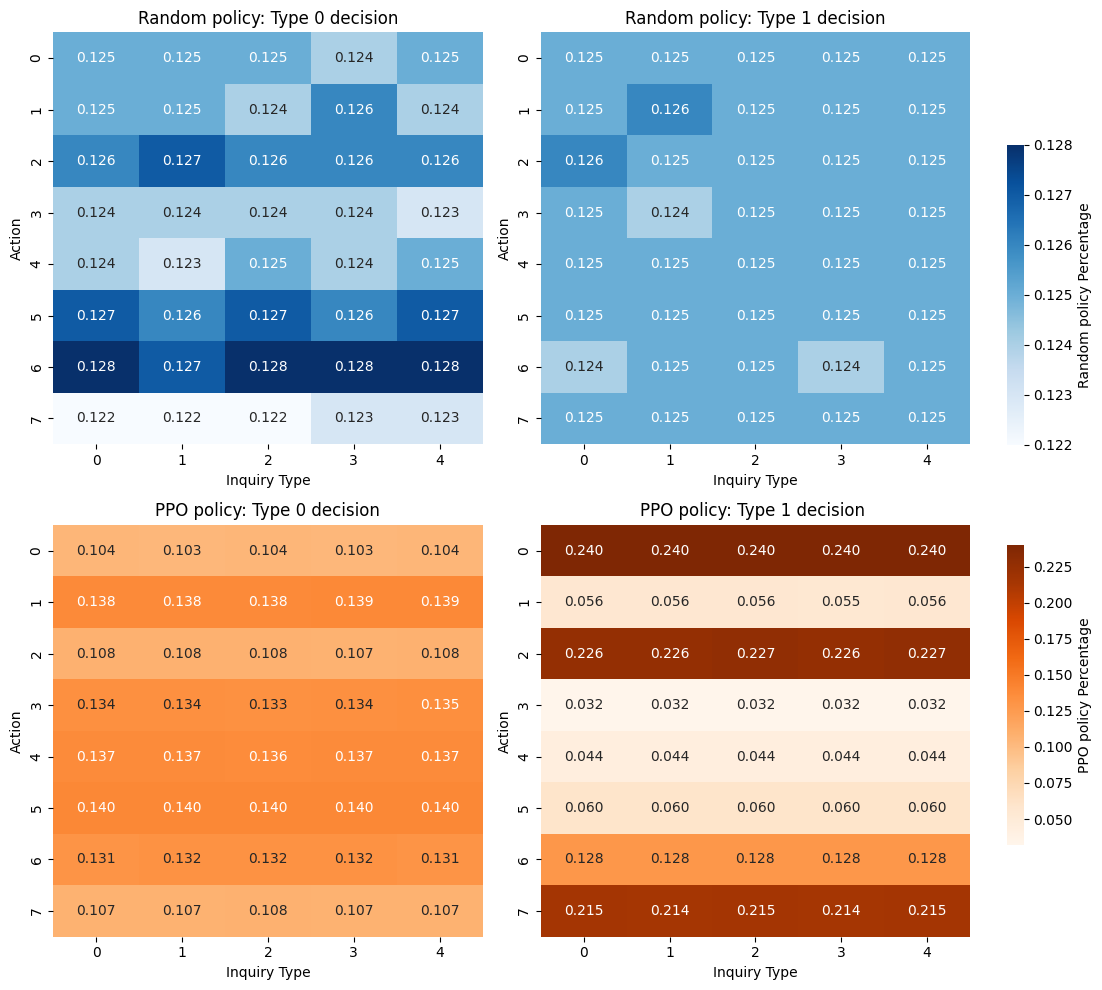

In [44]:
random_percentage_df = compute_grouped_action_percentages(random_df)
ppo_percentage_df = compute_grouped_action_percentages(ppo_df)
plot_decision_heatmaps(random_percentage_df, ppo_percentage_df)

### 2.2.2 Most Frequent Action by Queue and Callback Queue Lengt

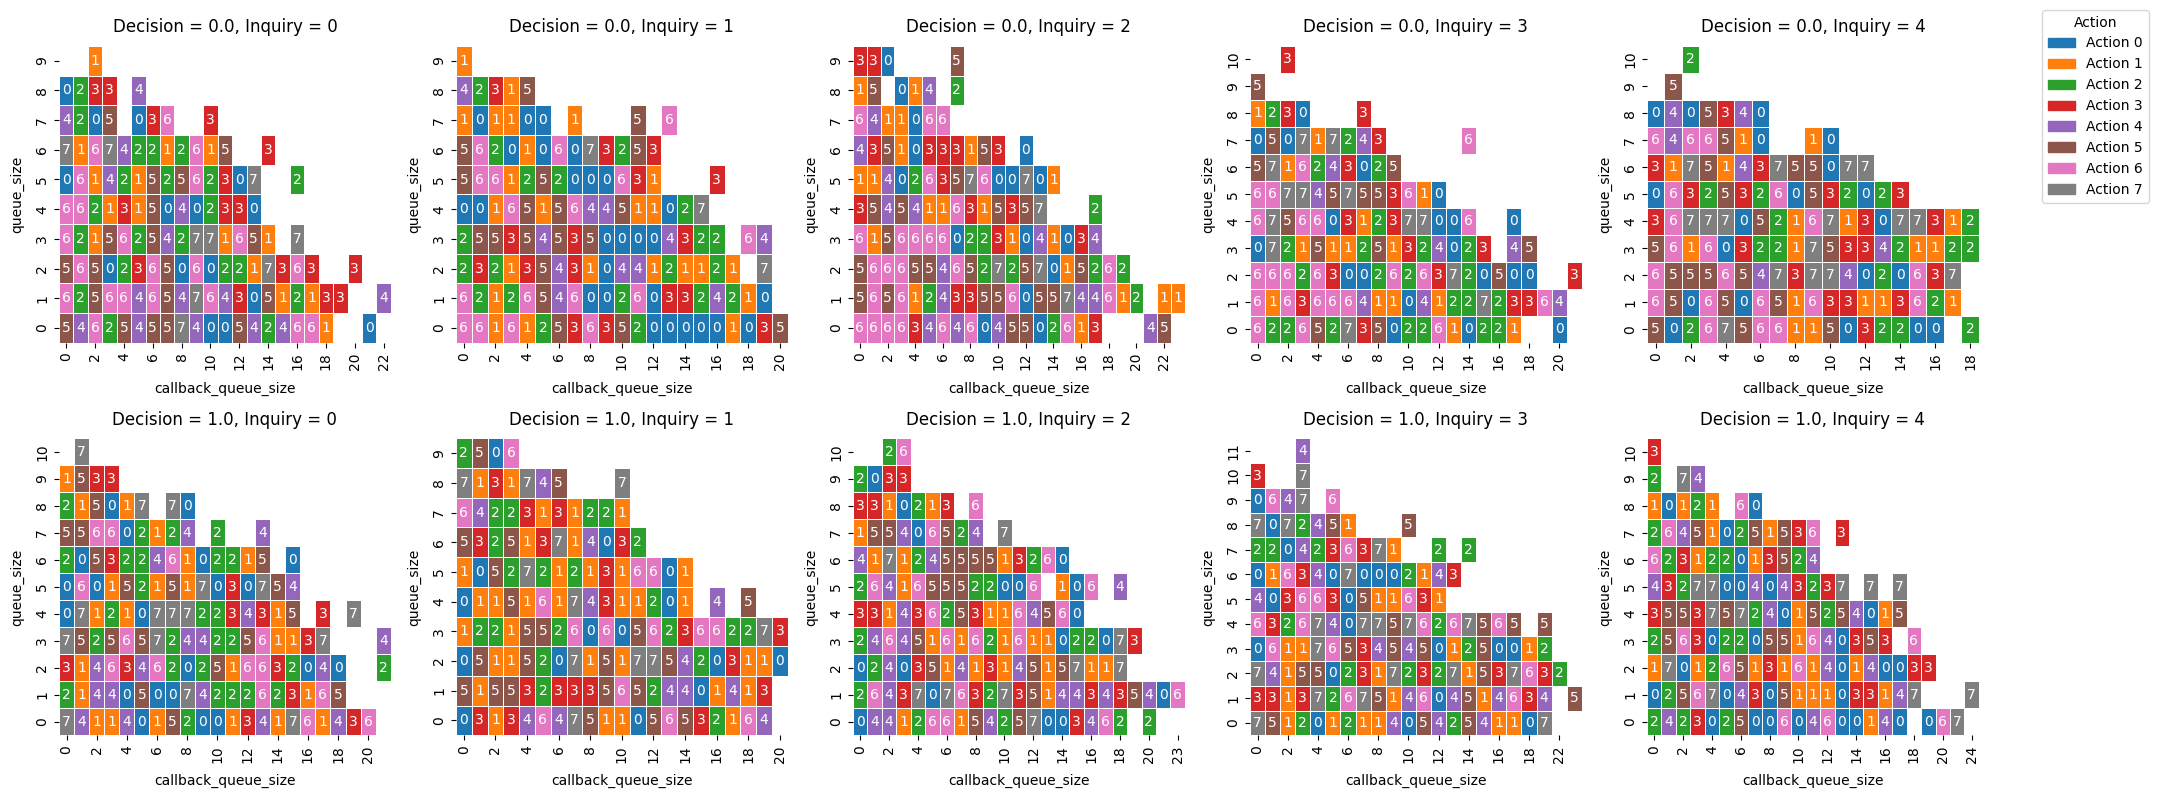

In [45]:
plot_action_heatmaps(random_df)

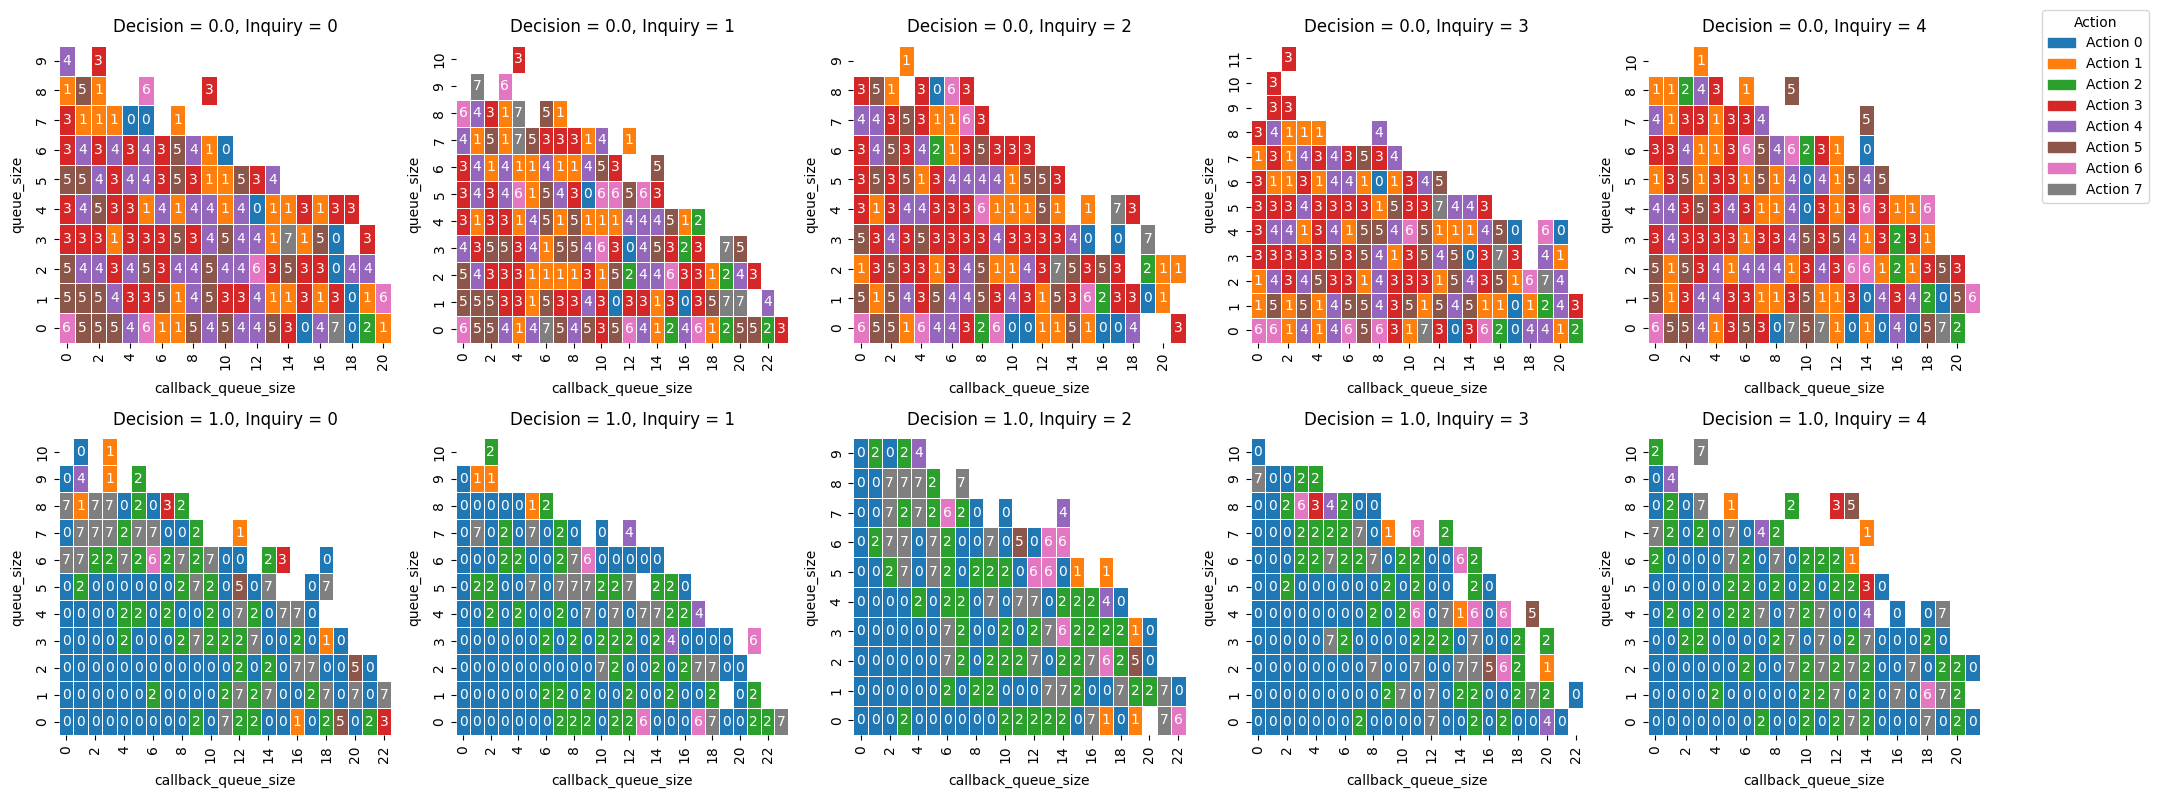

In [46]:
plot_action_heatmaps(ppo_df)

### 2.3 Simulation result

In [47]:
random_env = CallCentreEnv(scalee_up_parameters)
random_history = random_action_simulation(random_env, 1000)
# plot_history(random_history)

In [48]:
PPO_env = CallCentreEnvPPO(scalee_up_parameters)
model = MaskablePPO.load("./Project_Data/ppo_call_center")
PPO_history = model_simulation(PPO_env,model, "ppo")
# plot_history(PPO_history)

In [49]:
history_data = {
    "random": random_history,
    # "Value_Iteration": value_iteration_history,
    # 'Q_Learning': q_learning_history,
    "PPO": PPO_history
}

# 🔥 Specify metric filters
selected_exact = [
    'rewards', 
    'total_served', 
    'total_abandonments',
    'abandonment_rate',
    'total_callbacks_offered',
    'mean_idle_time',
    'mean_live_waiting_time',
    'mean_callback_waiting_time',
    'max_live_waiting_time',
    'max_callback_waiting_time'
]

# Collect metrics from the first available history to preserve order
first_model = next(iter(history_data.values()))
all_metrics_ordered = list(first_model.keys())

# 📝 Compute mean values for filtered metrics
filtered_history = {}
for metric in all_metrics_ordered:
    if (
        metric in selected_exact
    ):
        metric_values = []
        for model_name in history_data.keys():  # Preserve model order
            model_history = history_data[model_name]
            if metric in model_history:
                mean_value = np.mean(model_history[metric])
            else:
                mean_value = None
                print(f"Warning: Metric '{metric}' missing in model '{model_name}'.")
            metric_values.append(mean_value)
        filtered_history[metric] = metric_values

mean_history_data = dict()
for metric in history_data["random"].keys():
    metric_values = []
    for model_name in history_data.keys():  # Preserve model order
        model_history = history_data[model_name]
        mean_value = np.mean(model_history[metric])
        max_value = np.max(model_history[metric])
        if metric == 'max_callback_queue_size' or metric == 'max_staff_0_queue_size' or metric == 'max_staff_1_queue_size' or metric == 'max_staff_2_queue_size' or metric == 'max_staff_3_queue_size' or metric == 'max_staff_4_queue_size' or metric == 'max_staff_5_queue_size' or metric == 'max_staff_6_queue_size' or metric == 'max_staff_7_queue_size':
            result_value = max_value
        else:    
            result_value = mean_value
        metric_values.append(result_value)
    mean_history_data[metric] = metric_values

filtered_history 
simulation_result_df = pd.DataFrame(filtered_history, index=["Random", "PPO"]).T

# Calculate percentage change from Random to PPO
simulation_result_df["Change %"] = ((simulation_result_df["PPO"] - simulation_result_df["Random"]) / simulation_result_df["Random"].abs()) * 100

# Optional: round for readability
simulation_result_df = simulation_result_df.round(2)

simulation_result_df

,Random,PPO,Change %
rewards,-65753.41,-34482.07,47.56
total_served,441.66,477.07,8.02
total_abandonments,92.04,55.58,-39.61
abandonment_rate,0.17,0.10,-39.74
total_callbacks_offered,245.49,150.62,-38.65
mean_live_waiting_time,65.99,36.79,-44.25
mean_callback_waiting_time,84.17,104.03,23.59
max_live_waiting_time,564.20,525.78,-6.81
max_callback_waiting_time,504.18,453.48,-10.05
mean_idle_time,29476.17,8194.55,-72.20


## 3. Manual Play

In [50]:
# if __name__ == '__main__':

#     env = CallCentreEnv(parameters, random_run=False)
#     obs = env.reset()
#     done = False
#     reward_sum = 0
#     print(f"State: {obs}")
#     while not done:
#         env.render()
#         action = int(input("Enter an action (0 to num_staff or -1 to skip): "))
#         if action == -1:
#             print("Exiting the manual test.")
#             break

#         obs, reward, done, _ = env.step(action)
#         reward_sum += reward
#         print(f"Reward: {reward_sum}\n")
#         print(f"State: {obs}")
#         print("-" * 50)
#     print("Simulation ended.")

In [51]:
# pd.DataFrame(env.event_list()).to_csv("./Project_Data/demo_event_list.csv")